In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import joblib

In [2]:
random.seed(2000)


# Classifying NLP Data for the Service Industry: Comparing 2 Subreddits

## Project Contents:

This projects contains 4 notebooks:

|Name|Description|
|---|---|
|1.intro_and_webscrape|Provides an introduction to the project, including problem statement and background, and the code used for gathering the data.|
|2.eda|Displays data cleaning and exploratory data analysis.|
|3.modeling|Builds 4 classification models.|
|4.sentiment_analysis|Explores sentiment analysis of the language used in each subreddit|

You are currently in the notebook #3: Modeling.

# <a name="top"></a>Table of Contents

* [Baseline model](#baseline)
* [Logistic Regression Model #1 with TF IDF Vectorizer](#logreg1)
* [RandomForest](#randomforest)
* [MultinomialNB](#mnb)
* [SELECTED MODEL: LogisticRegression](#logreg_selected)
* [Overall Conclusions](#conclusion)

source for TOC functionality: https://stackoverflow.com/questions/5319754/cross-reference-named-anchor-in-markdown/7335259#7335259


In [198]:
#reading in the cleaned csv. 
df = pd.read_csv('./data/server_retail.csv')



In [200]:
df.sample(5)

,body,subreddit,author,created_utc,comment_length,comment_tokens
32068,People who think they know more than you are t...,TalesFromRetail,scootypuffs9,1611002039,159,people think know than are worst humans goddam...
70679,I got my vet assistant job because of my resta...,TalesFromYourServer,matchamontblanc,1631149834,522,got vet assistant job restaurant experience ir...
58034,Why thank you my waffle-y friend :),TalesFromYourServer,darkeyedchaos,1632713796,35,thank waffle-y friend )
10980,The nerve of some people,TalesFromRetail,latenightip,1627925318,24,nerve some people
66299,This is the answer. Never stay at the current ...,TalesFromYourServer,Original_Flounder_18,1631782134,76,answer never stay the current employer don value


In [201]:
#checking for nulls

df.isna().sum()


body                0
subreddit           0
author              0
created_utc         0
comment_length      0
comment_tokens    201
dtype: int64

In [202]:
# drop nulls in comment_tokens
df.dropna(inplace=True)



In [203]:
df.isna().sum()


body              0
subreddit         0
author            0
created_utc       0
comment_length    0
comment_tokens    0
dtype: int64

In [153]:
#Assigning my target(y) to the subreddit, and my predictor(x) to the comment text that has been cleaned. 

X = df['comment_tokens']
y = df['subreddit']


## <a name="baseline"></a>  Baseline Model 

My baseline model has an accuracy score of 0.53 - it will accurately predict the correct subreddict 53% of the time, because that is the size of the majority class in my dataset. 

* [Return to the the top of this notebook.](#top)
* [Jump to the Next Model](#logreg1)

In [154]:
#baseline model - Predicts TalesFromYourServer 53% of the time. 

round(y.value_counts(normalize=True), 2)



TalesFromYourServer    0.53
TalesFromRetail        0.47
Name: subreddit, dtype: float64

In [41]:
#splitting my training and testing data. 

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,  #test size of 0.33
                                                    stratify=y, #stratified, as necessary for a classification model. 
                                                    random_state=42)


# Models

## <a name="logreg1"></a>Logistic Regression Model #1 with TF IDF Vectorizer

For my first model in this notebook, I began with a Logistic Regression model. I created a pipeline for my transformer (TfidfVectorizer) and estimator (LogisticRegression). I preferred TfidfVectorizer for modeling in this study because I wanted to make sure to focus on words that were strongly related to one subreddit or the other, while putting less emphasis on the words that were common in both subreddits. 

I used a gridsearch to test the following features in this model:
* Max Features:  500, 1000, 2000 : to limit the number of features selected by the transformer. 
* ngram_range: to limit the transformer to ngrams and bigrams. 
* max_df: to ignore words that had a frequency above 90% versus the default of 100%. 
* Logistic Regression 'C' hyperparameter to set the alpha for regularization to .0001, .01, and 1.0. 

This model was not over or underfit, but the overall accuracy was low at only 60%.  I used the information gained from gridsearching over these hyperparameters to build a stronger Logistic Regression model at the bottom of this notebook, which turned out to be my strongest model overall. 

* [Return to the the top of this notebook.](#top)
* [Jump to the Next Model](#randomforest)

In [156]:
# Setting up a pipeline for TfidVectorizer as my transformer and LogisticRegression as the estimator. 

logreg_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])


In [157]:
# Setting hyperparameters, as described in the textblock above. 

logreg_pipe_params = {
    'tvec__max_features': [500, 1000, 2000],
    'tvec__ngram_range': [(1, 2)],
    'tvec__max_df': [.9, 1.0],
    'tvec__min_df': [.05, .2],
    'logreg__C': [.001, .01, 1.0]
}

In [44]:
#setting up the gridsearch with 3 crossfolds. 

logreg_gs = GridSearchCV(logreg_pipe,logreg_pipe_params, cv=3, verbose=1)


In [45]:
# UNCOMMENT THIS CODE TO RUN FIT ON MODEL
# Code has been commented out due to the time required to run this gridsearch. 

#Fitting the gridsearch on my training data and getting the score. 

# logreg_gs.fit(X_train, y_train)
# logreg_gs.score(X_train, y_train), logreg_gs.score(X_test, y_test)



Fitting 3 folds for each of 72 candidates, totalling 216 fits


(0.6060448367019837, 0.6082491653636479)

In [160]:
# Saving the model. 

# joblib.dump(logreg_gs, 'logreg_gs.pkl')



In [161]:
joblib.load('./models/logreg_gs.pkl').score(X_test, y_test)

0.6082491653636479

## <a name="randomforest"></a>RandomForest with TF IDF Vectorizer

For my second model in this notebook, I tested a RandomForest model. I created a pipeline for my transformer (TfidfVectorizer) and estimator (RandomForest). I preferred TfidfVectorizer for modeling in this study because I wanted to make sure to focus on words that were strongly related to one subreddit or the other, while putting less emphasis on the words that were common in both subreddits. 

I used a gridsearch to test the following features in this model:
* Max Features:  500, 1000, 2000, 3000 : to limit the number of features selected by the transformer. 
* ngram_range: to limit the transformer to ngrams and bigrams. 
* max_df: to ignore words that had a frequency above 70% or 90% versus the default of 100%. 
* RandomForest alpha hyperparameter to set the regularization to 0.0, .001, .01, and 1.0. 

This model was drastically overfit, with a training accuracy score of .98 and a testing accuracy score of .74. I would have liked to have performed more hyperparameter testing for this model to correct the bias, but this particular model took a very long time to fit. Given how strong my final LogisticRegression model performed, I decided not to move forward with RandomForest for this classification model. 

* [Return to the the top of this notebook.](#top)
* [Jump to the Next Model](#mnb)

In [48]:
# setting up my pipeline with TfidfVectorizer as my transformer and RandomForest as my estimator. 

rfc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])


In [49]:
# Desingating parameters to gridsearch over, as outlined in the textblock above. 

rfc_pipe_params = {
    'tvec__max_features': [500, 1000, 2000, 3000],
    'tvec__ngram_range': [(1, 2)],
    'tvec__max_df': [.7, .9, 1.0],
    'rfc__ccp_alpha': [0.0, .001, .01, 1.0]
}


In [50]:
#setting up my gridsearch

rfc_gs = GridSearchCV(rfc_pipe,rfc_pipe_params, cv=3, verbose=1)


In [51]:
# UNCOMMENT THIS CODE TO RUN FIT ON MODEL
# Code has been commented out due to the time required to run this gridsearch. 

# Fitting the gridsearch with my training data. 

# rfc_gs.fit(X_train, y_train)



Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__ccp_alpha': [0.0, 0.001, 0.01, 1.0],
                         'tvec__max_df': [0.7, 0.9, 1.0],
                         'tvec__max_features': [500, 1000, 2000, 3000],
                         'tvec__ngram_range': [(1, 2)]},
             verbose=1)

In [52]:
# This model is drastically overfit, and steps need to be taken to deal with the extreme bias highlighted by the accuracy scores. 

rfc_gs.score(X_train, y_train), rfc_gs.score(X_test, y_test)



(0.9813700797235695, 0.7485103325867388)

In [85]:
#  Looking at the results for each model. 

rfc_results_df = pd.DataFrame(rfc_gs.cv_results_)

In [189]:
rfc_results_df.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__ccp_alpha,param_tvec__max_df,param_tvec__max_features,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,43.926642,1.254246,1.548405,0.030499,0.0,1.0,3000,"(1, 2)","{'rfc__ccp_alpha': 0.0, 'tvec__max_df': 1.0, '...",0.744598,0.741726,0.739524,0.741950,0.002078,1
7,43.350136,0.633756,1.572793,0.025897,0.0,0.9,3000,"(1, 2)","{'rfc__ccp_alpha': 0.0, 'tvec__max_df': 0.9, '...",0.741851,0.741913,0.740024,0.741263,0.000876,2
3,43.693075,0.287183,1.585306,0.071349,0.0,0.7,3000,"(1, 2)","{'rfc__ccp_alpha': 0.0, 'tvec__max_df': 0.7, '...",0.741351,0.741039,0.738650,0.740347,0.001207,3
6,43.507940,0.155494,1.545082,0.051000,0.0,0.9,2000,"(1, 2)","{'rfc__ccp_alpha': 0.0, 'tvec__max_df': 0.9, '...",0.736855,0.740852,0.738400,0.738702,0.001646,4
2,43.031596,0.239244,1.707466,0.219523,0.0,0.7,2000,"(1, 2)","{'rfc__ccp_alpha': 0.0, 'tvec__max_df': 0.7, '...",0.737043,0.737355,0.736527,0.736975,0.000342,5


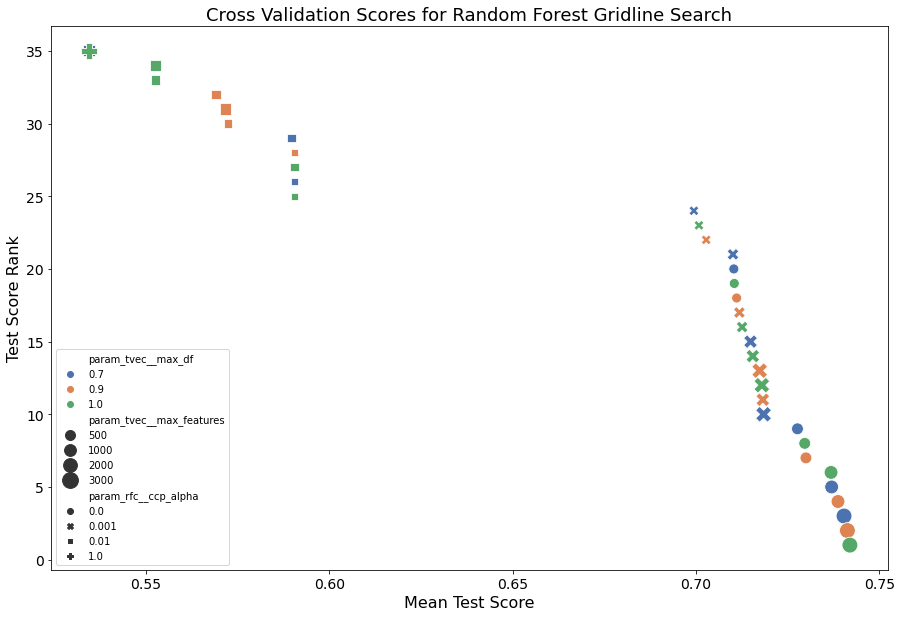

In [131]:
# Plotting the results from the RandomForest model gridsearch to visualize the scores and the impacts of the various hyperparameters. 

plt.figure(figsize=(15, 10))
sns.scatterplot(x=rfc_results_df['mean_test_score'], y=rfc_results_df['rank_test_score'], hue=rfc_results_df['param_tvec__max_df'],
                style=rfc_results_df['param_rfc__ccp_alpha'],size=rfc_results_df['param_tvec__max_features'], legend='full', palette="deep",
               sizes=[100, 140, 190, 250])
plt.ylabel('Test Score Rank', fontsize=16)
plt.xlabel('Mean Test Score', fontsize=16)
plt.title('Cross Validation Scores for Random Forest Gridline Search', fontsize=18)
plt.legend(markerscale=1,loc='lower left' ), 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);



Looking at the scatterplot above, we see that the highest test score by the RandomForest model was created with the following hyperparamters:

* TfidfVectorizer max_df: 1.0 - indicating that it was not beneficial to try to cut out words based on how often they occur in a given subreddit. 

* TfidfVectorizer max_features: 3000, which was the highest I allowed this gridsearch to go.  If I try this model again, I will try with higher max_features of 4000, 5000, and None. 

* RandomForest alpha:  0.  In fact, all of the highest scores came with an alpha of 0 in this gridsearch.  If I run the model again, I will maintain a 0 in this position. 



In [54]:
#saving the RandomForest model. 

# joblib.dump(logreg_gs, './models/rfc_gs.pkl')
joblib.load('./models/rfc_gs.pkl').score(X_test, y_test)



0.6082491653636479

## <a name="mnb"></a> MultinomialNB with CountVectorizer

For my third model in this notebook, I tested a MultinomialNB model with a Countvectorizor transformer. I created a pipeline to for my transformer (CountVectorizer) and estimator (MultinomialNB). 

I used a gridsearch to test out several hyperparameters for CountVectorizer, and to test various regularization settings for MultinomialNB. 

Even with testing out several alpha settings, I continued to get an overfit model, with a training accuracy score of .88 and a testing accuracy score of .79. 

The best parameters from this gridsearch were: 

*  'cvec__max_df': 0.85,
*  'cvec__max_features': None,
*  'cvec__min_df': 2,
*  'cvec__ngram_range': (1, 2),
*  'cvec__stop_words': 'english',
*  'nb__alpha': 1.0


Options:
* [Return to the the top of this notebook.](#top)
* [Jump to the Next Model](#logreg_selected)

In [169]:
# Setting up pipeline with transformer(cvec) and estimator(nb)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [176]:
# setting up hyperparameters for gridsearch. 

pipe_params = {
    'cvec__max_features': [None, 2_000],
    'cvec__min_df': [2, 3],
    'cvec__stop_words': ['english'],
    'cvec__max_df': [.85, .90],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [.01, .001, 1.0]
}

In [177]:
# instantiating gridsearch

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv = 3) 

In [178]:
# UNCOMMENT THIS CODE TO RUN FIT ON MODEL
# Code has been commented out due to the time required to run this gridsearch. 

# fitting the gridsearch model. 

# gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9],
                         'cvec__max_features': [None, 2000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'nb__alpha': [0.01, 0.001, 1.0]})

In [180]:
#training and testing accuracy scores

gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.8829749588892821, 0.794616067278029)

In [181]:
#checking best parameters used.

gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'nb__alpha': 1.0}

In [187]:
# saving the model. 

#joblib.dump(gs, './models/multinomialnb.pkl')

['./models/multinomialnb.pkl']

In [182]:
#  Looking at the cross validation results.

gs_results_df = pd.DataFrame(gs.cv_results_)

In [204]:
gs_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,param_nb__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.546951,0.003407,0.253967,0.002369,0.85,None,2,"(1, 1)",english,0.01,"{'cvec__max_df': 0.85, 'cvec__max_features': N...",0.783190,0.782315,0.780179,0.781895,0.001265,9
1,0.542767,0.000672,0.255290,0.002309,0.85,None,2,"(1, 1)",english,0.001,"{'cvec__max_df': 0.85, 'cvec__max_features': N...",0.780067,0.780442,0.777306,0.779272,0.001398,19
2,0.540304,0.001245,0.251858,0.000833,0.85,None,2,"(1, 1)",english,1.0,"{'cvec__max_df': 0.85, 'cvec__max_features': N...",0.787249,0.789497,0.787797,0.788181,0.000957,5
3,1.144430,0.022854,0.419355,0.015768,0.85,None,2,"(1, 2)",english,0.01,"{'cvec__max_df': 0.85, 'cvec__max_features': N...",0.780879,0.780317,0.776931,0.779376,0.001744,17
4,1.136340,0.023296,0.409344,0.012941,0.85,None,2,"(1, 2)",english,0.001,"{'cvec__max_df': 0.85, 'cvec__max_features': N...",0.775759,0.774760,0.771186,0.773901,0.001963,23


# <a name="logreg_selected"></a>Selected Model: LogisticRegression with TF IDF Vectorizer

For my fourth and final model in this notebook, I tested a simplied LogisticRegression model. I created a pipeline to for my transformer (TfidfVectorizer) and estimator (LogisticRegression). 

Instead of using a gridsearch for this model, I took what I'd learned in earlier model attempts and kept most settings as their defaults, but landed an alpha regularization setting of .15 after some testing. 

With this C setting, I was able to get a well fit model with an accuracy score of 0.78. 

* [Return to the the top of this notebook.](#top)
* [Jump to the Overall Conclusions](#conclusion)

In [60]:
# setting up a pipeline with my transformer and estimator and fitting/scoring with my training data. 

basic_lr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear', C=.15))
])

basic_lr_pipe.fit(X_train, y_train)
basic_lr_pipe.score(X_train, y_train), basic_lr_pipe.score(X_test, y_test)


(0.8134926417018796, 0.7804166842750285)

In [61]:
# saving the model. 

# joblib.dump(basic_lr_pipe, './models/winning_lr.pkl')


['./models/winning_lr.pkl']

In [62]:
joblib.load('./models/winning_lr.pkl').score(X_test, y_test)



0.7804166842750285

In [63]:
#cross_val_score

cross_val_score(basic_lr_pipe, X_train, y_train, cv = 3).mean().round(2)


0.77

In [69]:
# Generating prediction on my testing data. 
preds = basic_lr_pipe.predict(X_test)
# Save confusion matrix values based on the predictions and actuals from my testing data. 
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()



<Figure size 1440x1440 with 0 Axes>

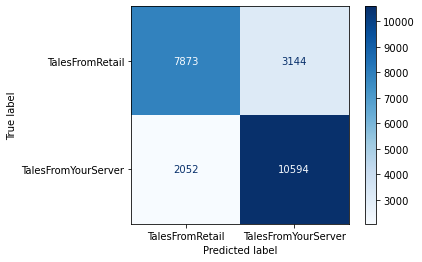

In [72]:
#plotting a confusion matrix in order to examine results.

plt.figure(figsize=(20, 20))
plot_confusion_matrix(basic_lr_pipe, X_test, y_test, cmap='Blues', values_format='d');



In the confusion matrix we are able to visualize the accuracy of the model, by viewing the model predictions plotted against the actual values. 

In [74]:
print(classification_report(y_test, preds))


                     precision    recall  f1-score   support

    TalesFromRetail       0.79      0.71      0.75     11017
TalesFromYourServer       0.77      0.84      0.80     12646

           accuracy                           0.78     23663
          macro avg       0.78      0.78      0.78     23663
       weighted avg       0.78      0.78      0.78     23663



Recall/sensitivity:  True positives out of ALL positives:  71% of cases where the model predicts TalesfromRetail it is correct, and in 84% of cases when it predicted TalesFromYourServer - meaning that it is incorrect in around 30% of cases.  If this were a classification model related to something like medical data, I would lower the threshold in the model. However, for this particular model I left the threshold as is in order to avoid increasing the false negatives generated. 


## ROC AUC

Because the ROC score of this Linear Regression model is so high, 0.87, it is further evidence that this model is a strong predictor of which subreddit text is originating from. These 2 subreddits aren't perfectly separated (which would be indicated by a score of 1.0), but they are far above the .5 score that would indicate that both subreddits are essentially identical. 

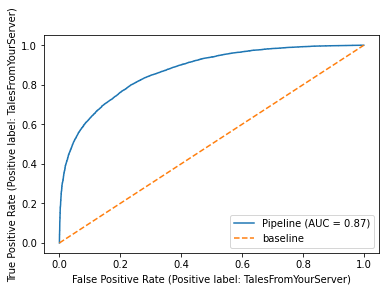

In [143]:
#ROC plot code is from General Assembly lesson 4.05.
plot_roc_curve(basic_lr_pipe, X_test, y_test)
plt.plot([0,1], [0,1], label = 'baseline', linestyle= '--')
plt.title('ROC')
plt.legend();

In [145]:
roc_auc_score(y_test, basic_lr_pipe.predict_proba(X_test)[:,1])

0.8704787050668362

## <a name="conclusion"></a>Overall Conclusions
* The model is able to differentiate between the TalesFromYourServer and the TalesFromRetail subreddits with about 80% accuracy.
* Generally, the sentiment from both groups is fairly neutral.
* Based on top word usage, it would appear that things like tips, food, and tables are important to servers, while things like customers are important to both servers and retail workers.